<a href="https://colab.research.google.com/github/wujulie/emotion_predict/blob/main/learning_emotion__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#載入函式庫


In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy

#讀取圖片、預處理


In [ ]:
import os,cv2
directory='/content/drive/MyDrive/基本情緒辨識教學/enhancement'
dir_list=os.listdir(directory)
image_data_list=[]
labels=[]
emotions=[]
l=0
for data_dir in dir_list:
    data_list=os.listdir(directory+'/'+data_dir)
    for img in data_list:
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img)
        input_img=cv2.resize(input_img,(64,64))
        image_data_list.append(input_img)
        labels.append(l)
    emotions.append(data_dir)
    l=l+1
img_data=np.array(image_data_list)
img_data=img_data/255
img_data.shape

(840, 64, 64, 3)

#查看資料內容

In [ ]:
for i in range(6):
    print('No of instances with class value '+ str(i) + ' : ' + str(labels.count(i)))

No of instances with class value 0 : 140
No of instances with class value 1 : 140
No of instances with class value 2 : 140
No of instances with class value 3 : 140
No of instances with class value 4 : 140
No of instances with class value 5 : 140


#分割資料集

In [ ]:
num_classes=6#one-hot encoding
Y = keras.utils.to_categorical(labels, num_classes)
X_train, X_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.2,shuffle= True, random_state=50)#訓練:測試=8:2
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,shuffle= False)#從測試集再切出驗證集 測試:驗證=5:5

#查看前五張圖片

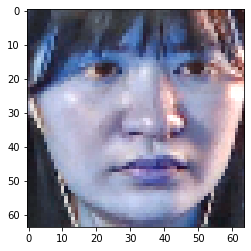

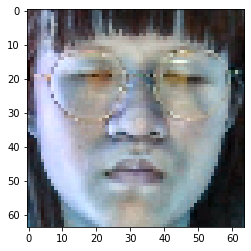

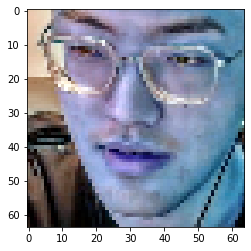

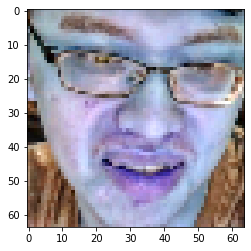

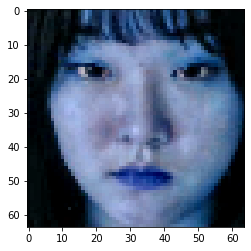

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(X_train[i])
    plt.show()

#載入VGG16模型

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
vgg_16=VGG16(weights='imagenet', include_top=True)#原始VGG16模型
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))#保留原始權重，自行修改前三層

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

#凍結前面幾層

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

#自行增加flatten、全連接層、輸出層

In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
for layer in vgg_model.layers:
  model.add(layer)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)       2

#定義模型loss function 與評估方法

In [ ]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

#訓練模型

In [ ]:
history=model.fit(X_train,y_train,epochs=20,validation_data=(X_val,y_val))

Epoch 1/20
21/21 [==============================] - 11s 61ms/step - loss: 1.1840 - accuracy: 0.5833 - val_loss: 0.6938 - val_accuracy: 0.7976
Epoch 2/20
21/21 [==============================] - 0s 17ms/step - loss: 0.7575 - accuracy: 0.7292 - val_loss: 0.6344 - val_accuracy: 0.7619
Epoch 3/20
21/21 [==============================] - 0s 18ms/step - loss: 0.5935 - accuracy: 0.7917 - val_loss: 0.5586 - val_accuracy: 0.8095
Epoch 4/20
21/21 [==============================] - 0s 17ms/step - loss: 0.5177 - accuracy: 0.8080 - val_loss: 0.4389 - val_accuracy: 0.8452
Epoch 5/20
21/21 [==============================] - 0s 17ms/step - loss: 0.4715 - accuracy: 0.8348 - val_loss: 0.5050 - val_accuracy: 0.8095
Epoch 6/20
21/21 [==============================] - 0s 18ms/step - loss: 0.4081 - accuracy: 0.8527 - val_loss: 0.8338 - val_accuracy: 0.6905
Epoch 7/20
21/21 [==============================] - 0s 17ms/step - loss: 0.3711 - accuracy: 0.8616 - val_loss: 0.4009 - val_accuracy: 0.8690
Epoch 8/20
2

#繪製準確度與loss


Text(0.5, 1.0, 'Loss')

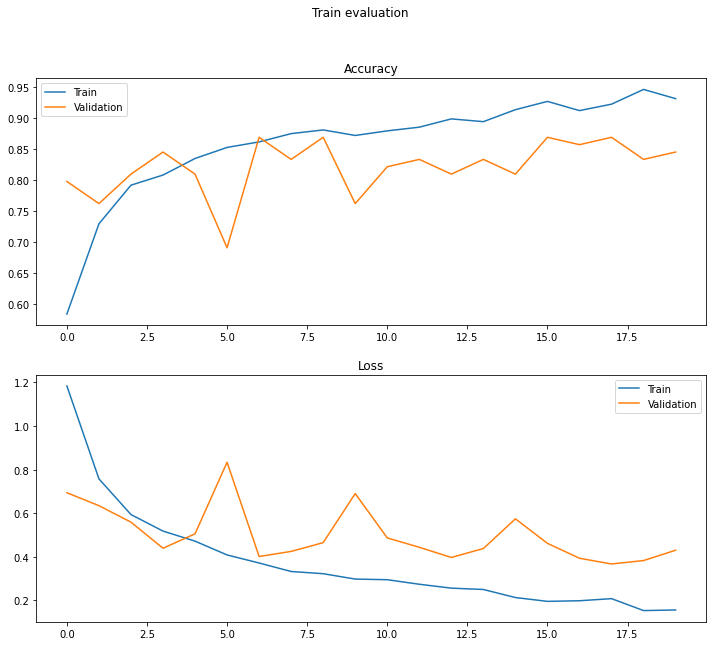

In [ ]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')

#混淆矩陣


In [ ]:
Y_pred=model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
print(Y_pred)

[1 4 5 4 1 0 4 4 3 4 4 3 3 1 4 2 5 0 5 4 3 4 5 0 1 3 0 3 5 0 3 1 4 4 5 5 4
 3 1 0 4 3 2 0 2 1 0 5 3 0 5 4 4 0 0 4 0 1 3 1 2 2 3 1 2 2 2 2 3 4 4 3 3 0
 0 1 3 1 2 4 1 3 5 3]


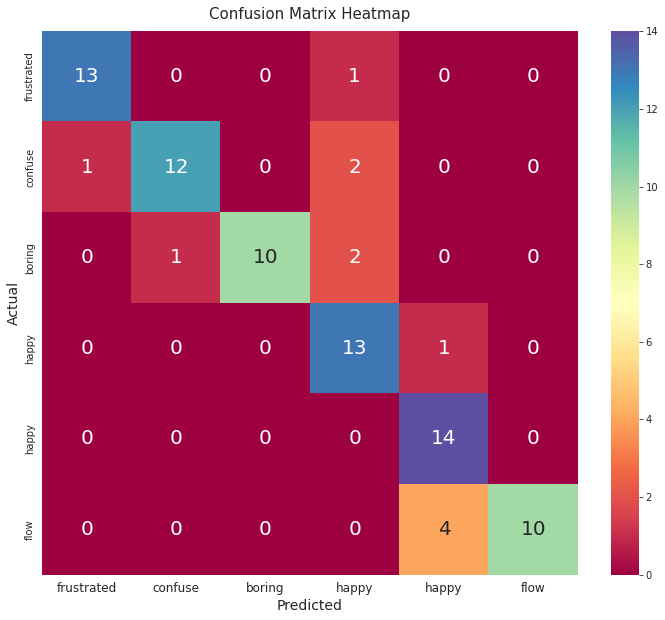

In [ ]:
conf_mat = confusion_matrix(np.where(y_test == 1)[1],Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['frustrated','confuse','boring','happy','happy','flow','surprise'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['frustrated','confuse','boring','happy','happy','flow','surprise'], fontdict={'fontsize':10})
plt.show()

#train、test、validation 準確度


In [ ]:
print('-Acuracy achieved on test set : {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(np.where(y_test == 1)[1],Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

-Acuracy achieved on test set : 85.71%
-Accuracy by model was: 93.15%
-Accuracy by validation was: 84.52%


In [ ]:
print(y_test)

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

In [ ]:
y_test = np.argmax(y_test, axis=1)
print(y_test)

[1 4 5 4 2 0 4 5 3 4 4 3 2 1 5 2 5 0 5 4 3 4 5 0 1 3 0 1 5 0 3 1 4 4 5 5 4
 0 1 0 4 3 2 1 2 1 0 5 2 0 5 5 4 0 0 4 0 1 1 1 2 2 3 1 2 2 2 2 3 4 5 3 3 0
 0 1 3 1 2 3 1 3 5 3]


In [ ]:
Y_pred=model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
print(Y_pred)

[1 4 5 4 1 0 4 4 3 4 4 3 3 1 4 2 5 0 5 4 3 4 5 0 1 3 0 3 5 0 3 1 4 4 5 5 4
 3 1 0 4 3 2 0 2 1 0 5 3 0 5 4 4 0 0 4 0 1 3 1 2 2 3 1 2 2 2 2 3 4 4 3 3 0
 0 1 3 1 2 4 1 3 5 3]


In [ ]:
X_test.shape

(84, 64, 64, 3)

#還原影像

In [ ]:
# import imageio

# for i in range(X_test.shape[0]):
#   B = X_test[i, :, :, 0]
#   imageio.imwrite("/content/drive/MyDrive/基本情緒辨識教學/predict_result/" + str(i) + "_testResults" + ".jpg", B)        
# for layer in model.layers:
#   print(layer.output_shape)

#還原影像並輸出預測結果

(1, 64, 64, 3)
[[2.9277989e-01 6.9951582e-01 7.6275738e-03 5.5896984e-05 4.6086657e-06
  1.6236310e-05]]
[[2.9277989e-01 6.9951582e-01 7.6275738e-03 5.5896984e-05 4.6086657e-06
  1.6236310e-05]]
[1]
label: 0
label: 1
label: 2
label: 3
label: 4
label: 5


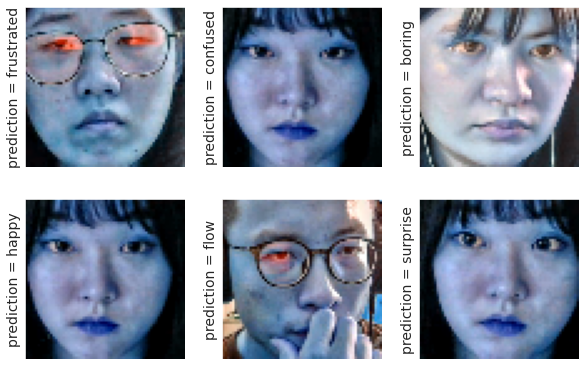

In [ ]:
test_image = X_test[0:1]#取第一張圖
print(test_image.shape)#看維度大小
print(model.predict(test_image))#預測<各類別的機率>
print(model.predict(test_image))#預測
print(y_test[0:1])#預測
res = model.predict(X_test[0:6])#前六張圖
plt.figure(figsize=(10, 10))
def getLabel(index):
  print('label:',index)
  return ['frustrated','confused','boring','happy','flow','surprise'][index]
for i in range(0, 6):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(i), fontsize=14)
# show the plot
plt.show()